In [1]:
import pickle
from typing import Optional
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gurobipy import GRB
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from plots import *
from ems_data import *
from simulation import *
from dataset import *
from linear_model import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 4
TIME_LIMIT = 60  # Just for testing

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str, metric_short: Optional[str] = None):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(metric)
    if metric_short is not None:
        metric = metric_short
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [2]:
N_AMBULANCES = 25  # 20, 25, 30

region_id = 5
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
n_stations = len(ems_data.stations)
print(f"# stations: {n_stations}")
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
X = dataset.drop(columns=METRICS).to_numpy()
Y = dataset[METRICS].to_numpy()

# for metric in METRICS:
#     y = Y[:, METRICS.index(metric)]
#     plot_metric(X, y, metric)

# stations: 20


In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [20, 25, 30]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_9min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_9min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {20: 0.3565014408893782, 25: 0.2769021029392569, 30: 0.2293679658137418}
SERVICE_RATE = {20: 21.448296831622255, 25: 21.869929046629107, 30: 21.966665014684228}


# Cov9

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Coverage (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Coverage (transformed)'>],
       dtype=object))

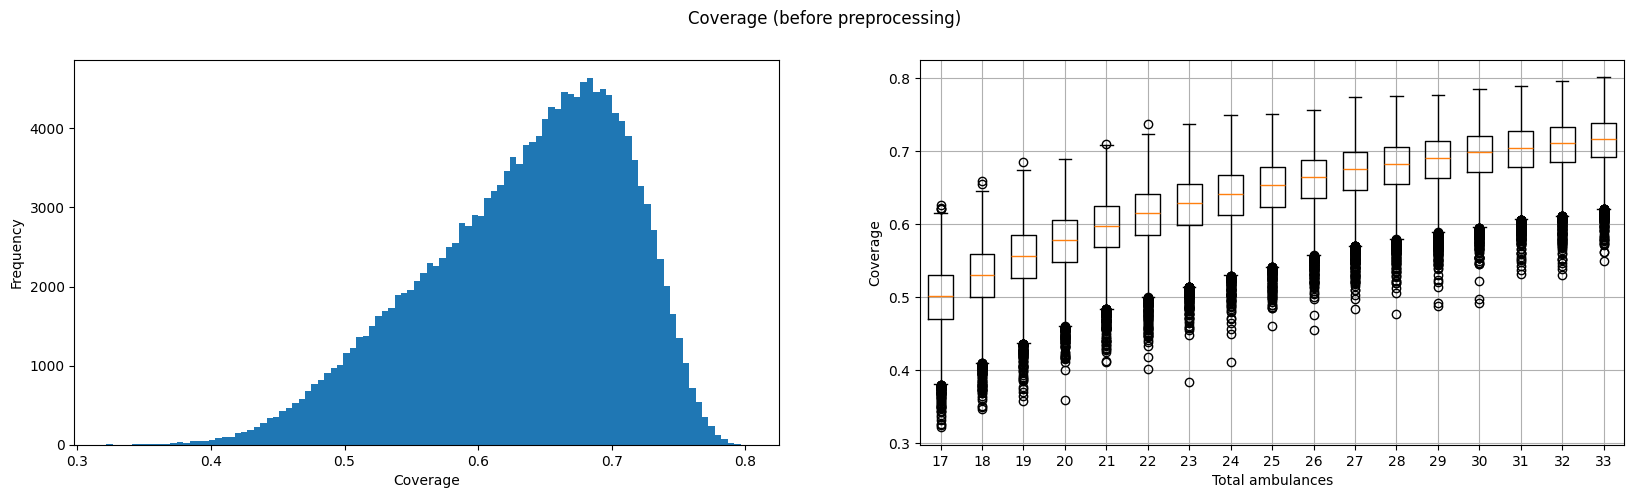

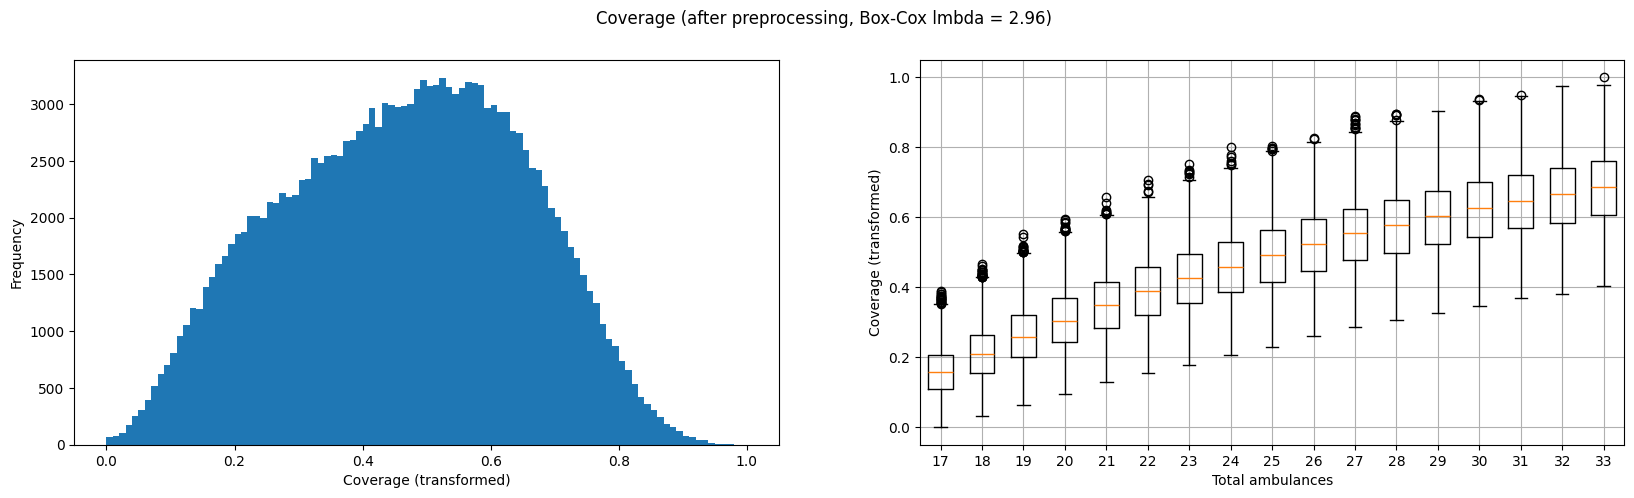

In [4]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.coverage_9min.to_numpy()
plot_metric(X, y, "Coverage (before preprocessing)", "Coverage")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Coverage (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Coverage (transformed)")

In [5]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/peel_coverage_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [6]:
with open('trained_ml_models/peel_coverage_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
(80,) (20, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 62 rows, 81 columns and 281 nonzeros
Model fingerprint: 0x0caa220a
Variable types: 1 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 3e+01]
Found heuristic solution: objective -0.6575472
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 61 rows, 80 columns, 200 nonzeros
Variable types: 0 continuous, 80 integer (80 binary)
Found heuristic solution: objective 0.6903017

Root relaxation: objective 9.123900e-01, 1 iterations, 0.00 seconds (0.00 work units)

    

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.723208,0.967612,0.074171,5.954047,5.398692,9.432339,0.279307,21.606874
1,0.725864,0.969460,0.074941,5.899967,5.352153,9.352996,0.282313,21.565676
2,0.729780,0.969116,0.074880,5.879251,5.349239,9.281322,0.278758,21.689999
3,0.724514,0.964591,0.074801,5.941412,5.336396,9.492727,0.285430,21.598939
4,0.723650,0.968281,0.074110,5.949905,5.407034,9.421671,0.280311,21.584841


In [7]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/peel_coverage_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [8]:
with open('trained_ml_models/peel_coverage_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12971 rows, 8668 columns and 34605 nonzeros
Model fingerprint: 0x5febddc1
Variable types: 4325 continuous, 4343 integer (4323 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 3e+01]
Found heuristic solution: objective 0.0295367
Presolve removed 2884 rows and 2775 columns
Presolve time: 0.32s
Presolved: 10087 rows, 5893 columns, 55615 nonzeros
Variable types: 0 continuous, 5893 integer (5873 binary)

Root relaxation: objective 9.242275e-01, 2725 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Obje

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.704183,0.966757,0.071130,6.098546,5.559467,9.414904,0.277842,21.759172
1,0.701569,0.966685,0.070692,6.135516,5.605469,9.502913,0.277297,21.511182
2,0.705592,0.967332,0.070950,6.118752,5.577472,9.528127,0.276030,21.685311
3,0.694259,0.966691,0.069903,6.190486,5.650223,9.668426,0.280431,21.522703
4,0.701134,0.964108,0.070306,6.163377,5.612755,9.756573,0.286250,21.558535


In [5]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='peel_coverage'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 62%|██████▏   | 62/100 [02:54<01:47,  2.82s/epoch, best_val_loss=0.000122, train_loss=0.000605, val_loss=0.000165]


Early stopping


 62%|██████▏   | 62/100 [02:58<01:49,  2.87s/epoch, best_val_loss=3.98e-5, train_loss=4.5e-5, val_loss=4.56e-5]  


Early stopping


100%|██████████| 100/100 [04:11<00:00,  2.51s/epoch, best_val_loss=3.26e-5, train_loss=3.26e-5, val_loss=3.26e-5]


In [9]:
weights, biases = MLP.load_npz('trained_ml_models/peel_coverage.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4039 rows, 3042 columns and 29079 nonzeros
Model fingerprint: 0xf0de8773
Variable types: 2022 continuous, 1020 integer (1000 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-03, 3e+01]
Found heuristic solution: objective -0.8224861
Presolve removed 62 rows and 46 columns
Presolve time: 0.05s
Presolved: 3977 rows, 2996 columns, 29188 nonzeros
Variable types: 1984 continuous, 1012 integer (992 binary)

Root relaxation: objective 3.113327e+00, 1351 iterations, 0.09 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.776709,0.977518,0.079565,5.515553,5.027017,8.592271,0.274001,22.002152
1,0.771620,0.975963,0.079433,5.544647,5.055554,8.612692,0.276034,21.875187
2,0.778736,0.976611,0.079774,5.528706,5.043932,8.548010,0.272617,21.949396
3,0.782833,0.976584,0.079480,5.538422,5.069930,8.547601,0.272922,21.904004
4,0.781271,0.977735,0.080236,5.484242,5.010407,8.467562,0.275021,21.870373


# SurvRate

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Survival rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Survival rate (transformed)'>],
       dtype=object))

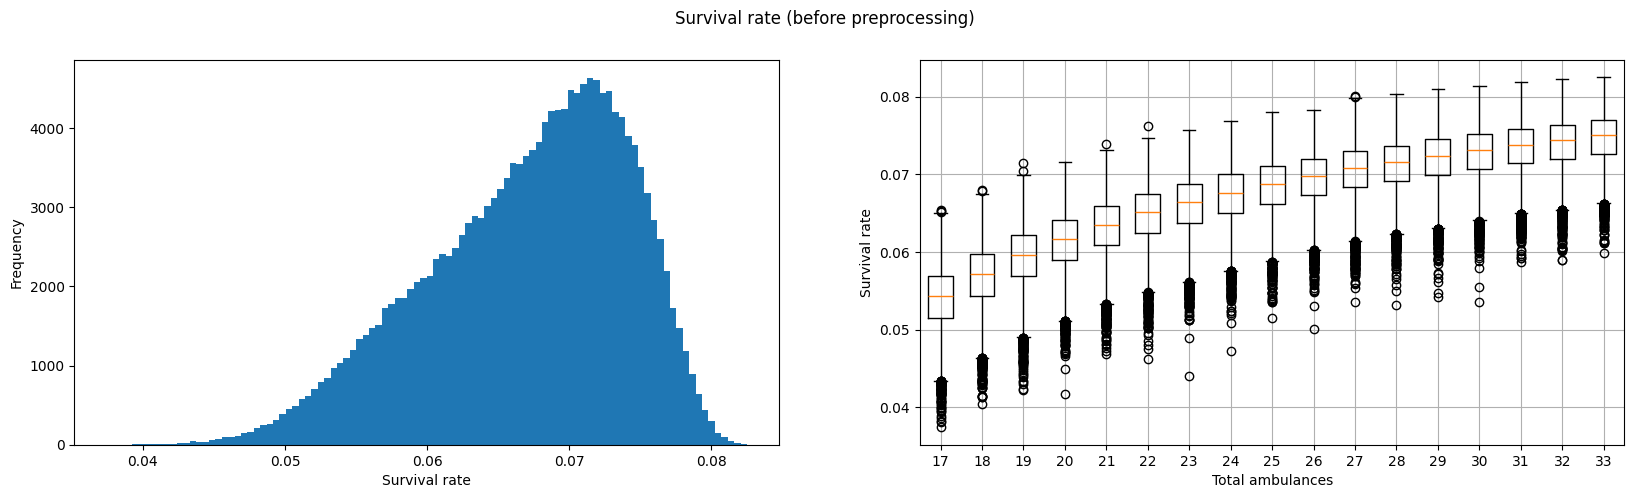

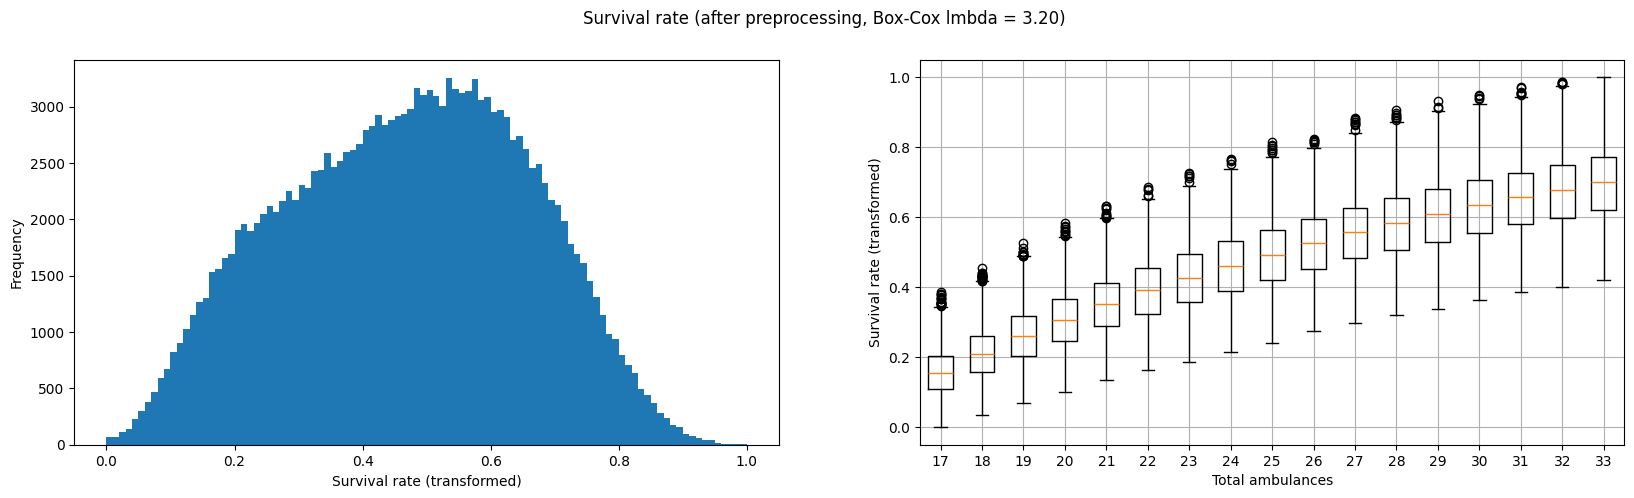

In [10]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.survival_rate.to_numpy()
plot_metric(X, y, "Survival rate (before preprocessing)", "Survival rate")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Survival rate (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Survival rate (transformed)")

In [11]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/peel_survival_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [12]:
with open('trained_ml_models/peel_survival_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(80,) (20, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 62 rows, 81 columns and 281 nonzeros
Model fingerprint: 0x4ac8b57a
Variable types: 1 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 3e+01]
Found heuristic solution: objective -0.7052129
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 61 rows, 80 columns, 200 nonzeros
Variable types: 0 continuous, 80 integer (80 binary)
Found heuristic solution: objective 0.6119405

Root relaxation: objective 8.950546e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.730293,0.965529,0.075568,5.890212,5.305315,9.306416,0.280374,21.637541
1,0.730772,0.964640,0.076083,5.894061,5.268698,9.468245,0.276824,21.686147
2,0.727861,0.963950,0.075621,5.915856,5.300523,9.501546,0.281856,21.717159
3,0.734863,0.966974,0.076293,5.833917,5.261945,9.307337,0.276934,21.765826
4,0.731562,0.968392,0.076022,5.854971,5.279356,9.343925,0.278813,21.640863


In [13]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/peel_survival_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [14]:
with open('trained_ml_models/peel_survival_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12890 rows, 8614 columns and 34389 nonzeros
Model fingerprint: 0xcc6fb09c
Variable types: 4298 continuous, 4316 integer (4296 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 3e+01]
Found heuristic solution: objective 0.0489751
Presolve removed 2842 rows and 2760 columns
Presolve time: 0.29s
Presolved: 10048 rows, 5854 columns, 55360 nonzeros
Variable types: 0 continuous, 5854 integer (5834 binary)

Root relaxation: objective 9.205667e-01, 2749 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Current Node    |     Obje

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.718328,0.955512,0.072916,6.155318,5.467562,9.581534,0.278523,21.811595
1,0.717884,0.953771,0.072175,6.197446,5.450726,9.635156,0.275313,21.731434
2,0.719776,0.954242,0.072258,6.197278,5.480875,9.643160,0.278925,21.711375
3,0.713212,0.954707,0.072608,6.221644,5.479783,9.723550,0.280297,21.635904
4,0.714728,0.955387,0.072132,6.203235,5.496289,9.608970,0.279834,21.682607


In [9]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='peel_survival'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 90%|█████████ | 90/100 [04:20<00:28,  2.90s/epoch, best_val_loss=0.000141, train_loss=0.000652, val_loss=0.000211]


Early stopping


 74%|███████▍  | 74/100 [03:34<01:15,  2.90s/epoch, best_val_loss=3.97e-5, train_loss=4.39e-5, val_loss=4.73e-5] 


Early stopping


100%|██████████| 100/100 [04:13<00:00,  2.54s/epoch, best_val_loss=3.26e-5, train_loss=3.26e-5, val_loss=3.26e-5]


In [15]:
weights, biases = MLP.load_npz('trained_ml_models/peel_survival.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4049 rows, 3042 columns and 29089 nonzeros
Model fingerprint: 0x207c1729
Variable types: 2022 continuous, 1020 integer (1000 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [9e-04, 3e+01]
Found heuristic solution: objective -0.5752502
Presolve removed 88 rows and 62 columns
Presolve time: 0.07s
Presolved: 3961 rows, 2980 columns, 29607 nonzeros
Variable types: 1973 continuous, 1007 integer (987 binary)

Root relaxation: objective 3.553106e+00, 1534 iterations, 0.11 seconds (0.25 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.776605,0.978297,0.080290,5.485536,5.010429,8.529416,0.277874,21.936864
1,0.772676,0.978031,0.079870,5.500397,5.035102,8.601609,0.276654,21.971594
2,0.773451,0.979899,0.079774,5.509901,5.071309,8.580233,0.275800,21.852418
3,0.777396,0.977621,0.080121,5.515185,5.043855,8.621240,0.275608,21.970358
4,0.774806,0.978719,0.080083,5.501102,5.018259,8.621144,0.277155,21.900046


# RTMean

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean response time (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Mean response time (transformed)'>],
       dtype=object))

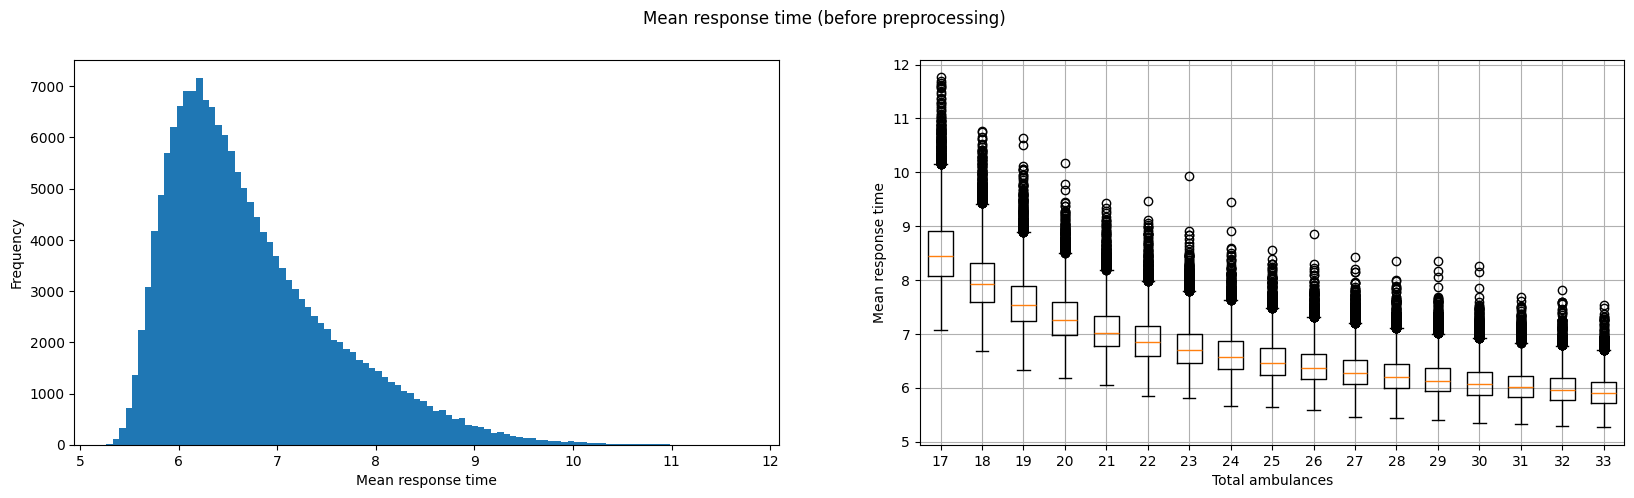

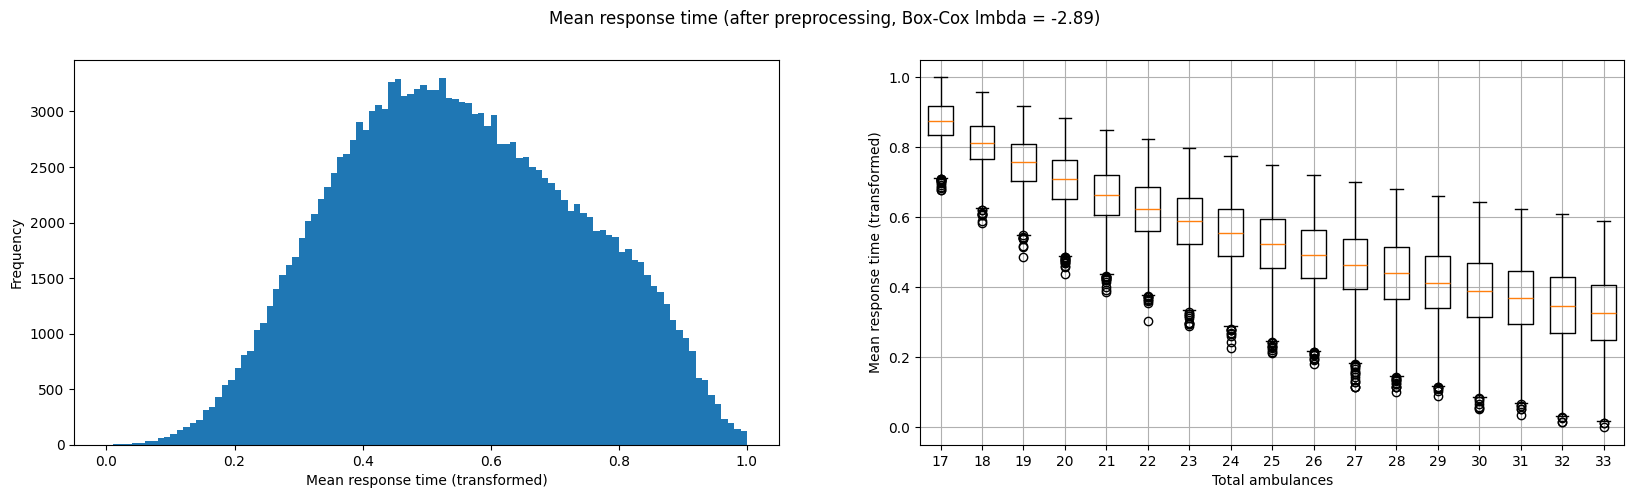

In [16]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.response_time_mean.to_numpy()
plot_metric(X, y, "Mean response time (before preprocessing)", "Mean response time")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Mean response time (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Mean response time (transformed)")

In [17]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/peel_median_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [18]:
with open('trained_ml_models/peel_median_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(80,) (20, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 62 rows, 81 columns and 281 nonzeros
Model fingerprint: 0x41c8d2a9
Variable types: 1 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+01]
Found heuristic solution: objective 1.6773734
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolved: 60 rows, 79 columns, 197 nonzeros
Variable types: 0 continuous, 79 integer (79 binary)
Found heuristic solution: objective 0.3060312

Root relaxation: objective 1.271434e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.709930,0.960943,0.073669,6.062384,5.421616,9.839872,0.280154,21.489092
1,0.712421,0.958066,0.073504,6.109281,5.455450,9.832656,0.281609,21.431553
2,0.704251,0.959335,0.072897,6.110296,5.449034,9.855631,0.281114,21.536514
3,0.702780,0.958556,0.073464,6.104167,5.437267,9.917329,0.284765,21.511655
4,0.697841,0.955897,0.072325,6.197635,5.476648,10.003830,0.283272,21.504136


In [19]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/peel_median_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [20]:
with open('trained_ml_models/peel_median_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13028 rows, 8706 columns and 34757 nonzeros
Model fingerprint: 0xc15e9490
Variable types: 4344 continuous, 4362 integer (4342 binary)
Coefficient statistics:
  Matrix range     [6e-02, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 3e+01]
Found heuristic solution: objective 0.9558605
Presolve removed 2877 rows and 2784 columns
Presolve time: 0.28s
Presolved: 10151 rows, 5922 columns, 55876 nonzeros
Variable types: 0 continuous, 5922 integer (5902 binary)

Root relaxation: objective 6.046771e-02, 1527 iterations, 0.15 seconds (0.37 work units)

    Nodes    |    Current Node    |     Obje

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.484314,0.793399,0.051139,10.100798,7.115535,19.843403,0.514980,19.800695
1,0.489062,0.794145,0.051227,10.131888,7.052157,20.308823,0.514817,19.762859
2,0.505800,0.814267,0.053098,9.801250,6.881646,18.648950,0.497261,20.106892
3,0.484290,0.789276,0.050930,10.308961,7.116257,20.293535,0.519152,19.765408
4,0.501102,0.803286,0.052182,10.055496,6.963980,19.632591,0.497383,20.056913


In [13]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='peel_median'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 74%|███████▍  | 74/100 [03:37<01:16,  2.93s/epoch, best_val_loss=0.000148, train_loss=0.000666, val_loss=0.000238]


Early stopping


 75%|███████▌  | 75/100 [03:34<01:11,  2.85s/epoch, best_val_loss=4.5e-5, train_loss=4.84e-5, val_loss=5.86e-5]  


Early stopping


100%|██████████| 100/100 [04:08<00:00,  2.49s/epoch, best_val_loss=3.48e-5, train_loss=3.5e-5, val_loss=3.5e-5] 


In [21]:
weights, biases = MLP.load_npz('trained_ml_models/peel_median.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4039 rows, 3042 columns and 29079 nonzeros
Model fingerprint: 0x1c8125bb
Variable types: 2022 continuous, 1020 integer (1000 binary)
Coefficient statistics:
  Matrix range     [8e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [6e-04, 3e+01]
Found heuristic solution: objective 1.8401738
Presolve removed 62 rows and 46 columns
Presolve time: 0.05s
Presolved: 3977 rows, 2996 columns, 29319 nonzeros
Variable types: 1984 continuous, 1012 integer (992 binary)

Root relaxation: objective -3.404338e+00, 1652 iterations, 0.12 seconds (0.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.770126,0.978850,0.079282,5.531632,5.083099,8.699450,0.276703,21.862993
1,0.773735,0.978757,0.079872,5.499900,5.061065,8.607544,0.278337,21.910428
2,0.770837,0.978528,0.079296,5.548148,5.108174,8.624097,0.281309,21.844684
3,0.770719,0.977481,0.079350,5.558521,5.090296,8.635085,0.278723,21.725544
4,0.777265,0.979835,0.079518,5.506726,5.081593,8.500291,0.278198,21.805104
